# 4 задание 
#### Подбор параметров динамической системы методом MCMC

Требуется найти параметры системы Хищник-Жертва при помощи метода MCMC. 
Результатом является записная книжка Python Notebook в которой: 

1)Задаются параметры системы Хищник-Жертва 

2)Решается прямая задача и генерируются данные 

3)К данными применяется зашумление 

4)Методом MCMC оцениваются параметры системы по зашумленным данным 

# Решение
Система Хищник-Жертва

$ dx/dt = x ( \alpha - \beta y ) $

$ dy/dt = -y( \gamma - \delta x ) $

 $\alpha$  — коэффициент рождаемости жертв, x — величина популяции жертв, dx/dt  — скорость прироста популяции жертв,
 $\gamma$  — коэффициент убыли хищников, y — величина популяции хищников, dy/dt — скорость прироста популяции хищников.
 
 При встречах хищников и жертв (частота которых прямо пропорциональна величине xy) происходит убийство жертв с коэффициентом $\beta$ , сытые хищники способны к воспроизводству с коэффициентом $\delta$ . 

In [31]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

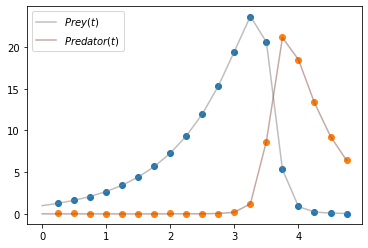

In [32]:
def PredatorPrey(y, t, p):
    dx = (p[0] - p[1]*y[1])*y[0]
    dy = (-p[2] + p[3]*y[0])*y[1]
    return [dx, dy]


times = np.arange(0, 5, 0.25)

# parametrs Predator-Prey
alpha = 1.
beta = 0.4
gamma = 1.5
delta = 0.4

# Create true curves

y = odeint(PredatorPrey, t=times, y0=[0.99, 0.01], args=((alpha, beta, gamma, delta),), rtol=1e-8)

yobs = np.clip(np.random.normal(loc = y[1::], scale = 0.05), a_min = 0, a_max = None)

plt.plot(times[1::], yobs, marker="o", linestyle="none")
plt.plot(times, y[:, 0], color="C7", alpha=0.5, label=f"$Prey(t)$")
plt.plot(times, y[:, 1], color="C5", alpha=0.5, label=f"$Predator(t)$")
plt.legend()
plt.show()

In [33]:
PredatorPrey_model = DifferentialEquation(
    func=PredatorPrey,
    times=np.arange(0.25, 5, 0.25), # не включаем начальную точку
    n_states=2, # Размерность системы ОДУ 
    n_theta=4, # Размерность вектора параметров
    t0=0,
)

In [34]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)
    # предполагаем, что величины равномерно распределены в диапазоне от 0.1 до 10
    alpha = pm.Uniform("alpha", 0.1, 1.0)
    beta = pm.Uniform("beta", 0.1, 1.0)
    gamma = pm.Uniform("gamma", 0.1, 1.0)
    delta = pm.Uniform("delta", 0.1, 1.0)
    # решение дифф уравнения для параметров 
    PredatorPrey_curves = PredatorPrey_model(y0=[0.5, 0.5], theta=[alpha, beta, gamma, delta])

    Y = pm.Normal("Y", mu=PredatorPrey_curves, sigma=sigma, observed=yobs)

    trace = pm.sample(80, tune=40, target_accept=0.9, cores=1) # trace - след, отобранные нами точки
    data = az.from_pymc3(trace=trace)

<ipython-input-34-3abd81d35a9b>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(80, tune=40, target_accept=0.9, cores=1) # trace - след, отобранные нами точки
Only 80 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [delta, gamma, beta, alpha, sigma]


Sampling 2 chains for 40 tune and 80 draw iterations (80 + 160 draws total) took 1705 seconds.
C:\Users\Asus\anaconda3\lib\site-packages\pymc3\sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


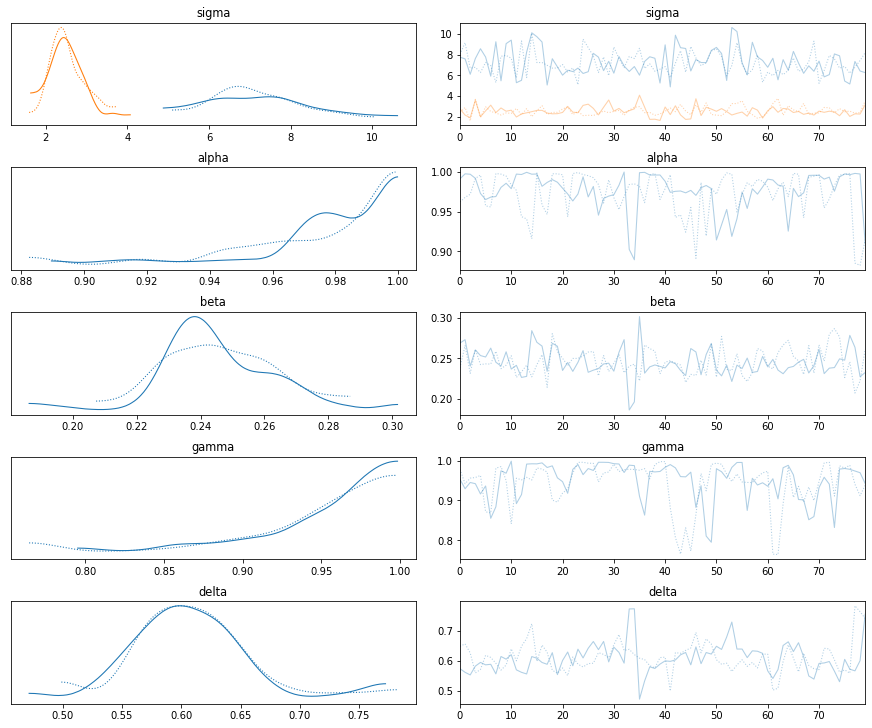

In [35]:
with model4:
    az.plot_trace(trace)
# ранее были выбраны точки и теперь видно как меняются параметры

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B404B5E7F0>,
      dtype=object)

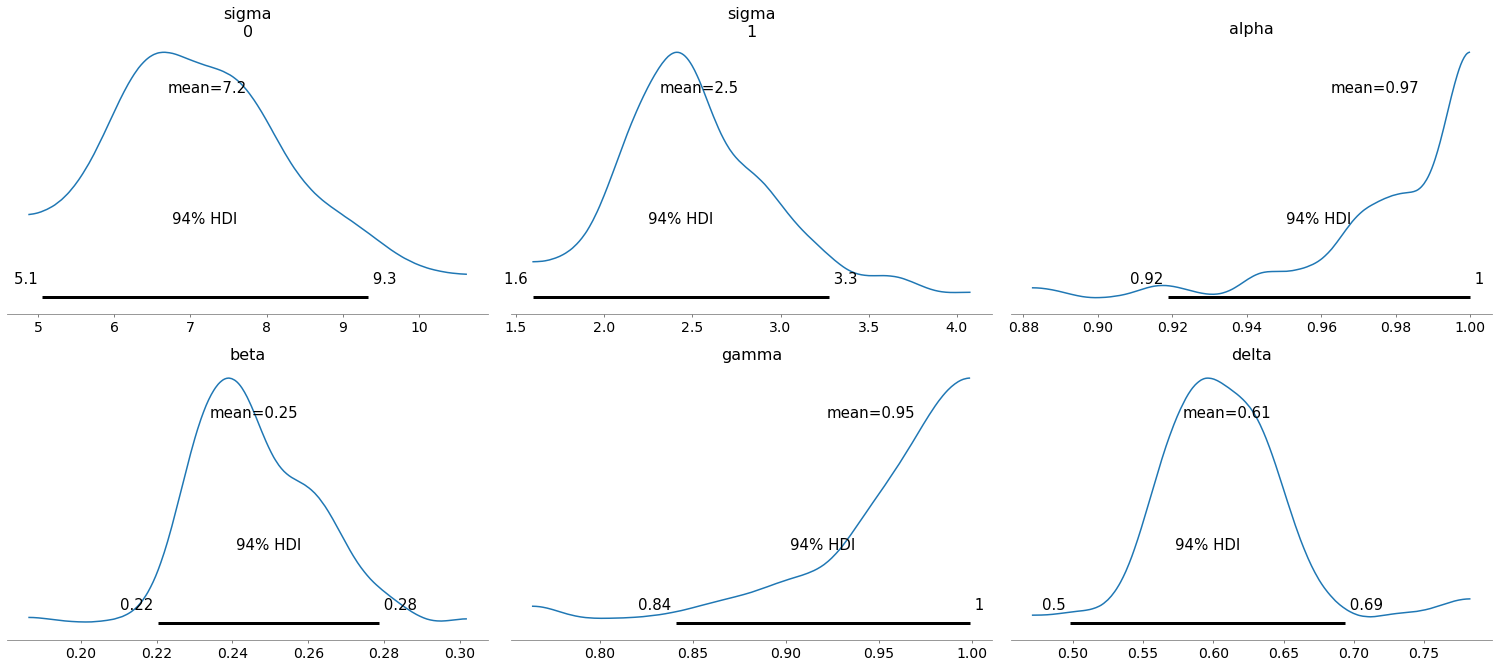

In [36]:
az.plot_posterior(data, round_to=2)
# оценка параметров в зависимости от наблюдаемых данных
# получено распределение

Выполнила Брындина Анна 305 группа